# 0.3.0 Named-entity recognition

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from nltk import pos_tag, ne_chunk_sents
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from gensim.corpora.dictionary import Dictionary

from gensim.models.tfidfmodel import TfidfModel

import spacy

import itertools
from collections import defaultdict

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append("../") 

from utils.info import article_m3
import utils.paths as path
from utils.paths2 import direcciones, direcciones_cursos

## 0.3.2 NER with NLTK

In [4]:
# Tokenize the article into sentences: sentences
sentences = sent_tokenize(article_m3)
sentences

['\ufeffThe taxi-hailing company Uber brings into very sharp focus the question of whether corporations can be said to have a moral character.',
 'If any human being were to behave with the single-minded and ruthless greed of the company, we would consider them sociopathic.',
 'Uber wanted to know as much as possible about the people who use its service, and those who don’t.',
 'It has an arrangement with unroll.me, a company which offered a free service for unsubscribing from junk mail, to buy the contacts unroll.me customers had had with rival taxi companies.',
 'Even if their email was notionally anonymised, this use of it was not something the users had bargained for.',
 'Beyond that, it keeps track of the phones that have been used to summon its services even after the original owner has sold them, attempting this with Apple’s phones even thought it is forbidden by the company.',
 'Uber has also tweaked its software so that regulatory agencies that the company regarded as hostile 

In [5]:
# Tokenize each sentence into words: token_sentences
token_sentences = [word_tokenize(sent) for sent in sentences]
token_sentences

[['\ufeffThe',
  'taxi-hailing',
  'company',
  'Uber',
  'brings',
  'into',
  'very',
  'sharp',
  'focus',
  'the',
  'question',
  'of',
  'whether',
  'corporations',
  'can',
  'be',
  'said',
  'to',
  'have',
  'a',
  'moral',
  'character',
  '.'],
 ['If',
  'any',
  'human',
  'being',
  'were',
  'to',
  'behave',
  'with',
  'the',
  'single-minded',
  'and',
  'ruthless',
  'greed',
  'of',
  'the',
  'company',
  ',',
  'we',
  'would',
  'consider',
  'them',
  'sociopathic',
  '.'],
 ['Uber',
  'wanted',
  'to',
  'know',
  'as',
  'much',
  'as',
  'possible',
  'about',
  'the',
  'people',
  'who',
  'use',
  'its',
  'service',
  ',',
  'and',
  'those',
  'who',
  'don',
  '’',
  't',
  '.'],
 ['It',
  'has',
  'an',
  'arrangement',
  'with',
  'unroll.me',
  ',',
  'a',
  'company',
  'which',
  'offered',
  'a',
  'free',
  'service',
  'for',
  'unsubscribing',
  'from',
  'junk',
  'mail',
  ',',
  'to',
  'buy',
  'the',
  'contacts',
  'unroll.me',
  'custom

In [6]:
# Tag each tokenized sentence into parts of speech: pos_sentences
pos_sentences = [pos_tag(sent) for sent in token_sentences]
pos_sentences

[[('\ufeffThe', 'JJ'),
  ('taxi-hailing', 'JJ'),
  ('company', 'NN'),
  ('Uber', 'NNP'),
  ('brings', 'VBZ'),
  ('into', 'IN'),
  ('very', 'RB'),
  ('sharp', 'JJ'),
  ('focus', 'VB'),
  ('the', 'DT'),
  ('question', 'NN'),
  ('of', 'IN'),
  ('whether', 'IN'),
  ('corporations', 'NNS'),
  ('can', 'MD'),
  ('be', 'VB'),
  ('said', 'VBD'),
  ('to', 'TO'),
  ('have', 'VB'),
  ('a', 'DT'),
  ('moral', 'JJ'),
  ('character', 'NN'),
  ('.', '.')],
 [('If', 'IN'),
  ('any', 'DT'),
  ('human', 'JJ'),
  ('being', 'VBG'),
  ('were', 'VBD'),
  ('to', 'TO'),
  ('behave', 'VB'),
  ('with', 'IN'),
  ('the', 'DT'),
  ('single-minded', 'JJ'),
  ('and', 'CC'),
  ('ruthless', 'JJ'),
  ('greed', 'NN'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('company', 'NN'),
  (',', ','),
  ('we', 'PRP'),
  ('would', 'MD'),
  ('consider', 'VB'),
  ('them', 'PRP'),
  ('sociopathic', 'JJ'),
  ('.', '.')],
 [('Uber', 'NNP'),
  ('wanted', 'VBD'),
  ('to', 'TO'),
  ('know', 'VB'),
  ('as', 'RB'),
  ('much', 'JJ'),
  ('as', 'IN'),

In [7]:
# Create the named entity chunks: chunked_sentences
chunked_sentences = ne_chunk_sents(pos_sentences, binary=True)
chunked_sentences

<generator object ParserI.parse_sents.<locals>.<genexpr> at 0x0000023963A2CB40>

In [8]:
# Test for stems of the tree with 'NE' tags
for sent in chunked_sentences:
    for chunk in sent:
        if hasattr(chunk, "label") and chunk.label() == "NE":
            print(chunk)

(NE Uber/NNP)
(NE Beyond/NN)
(NE Apple/NNP)
(NE Uber/NNP)
(NE Uber/NNP)
(NE Travis/NNP Kalanick/NNP)
(NE Tim/NNP Cook/NNP)
(NE Apple/NNP)
(NE Silicon/NNP Valley/NNP)
(NE CEO/NNP)
(NE Yahoo/NNP)
(NE Marissa/NNP Mayer/NNP)


## 0.3.3 Charting practice

In [9]:
# Create the defaultdict: ner_categories
ner_categories = defaultdict(int)

In [10]:
# Create the nested for loop
for sent in chunked_sentences:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            ner_categories[chunk.label()] += 1
            
# Create a list from the dictionary keys for the chart labels: labels
labels = list(ner_categories.keys())
labels

[]

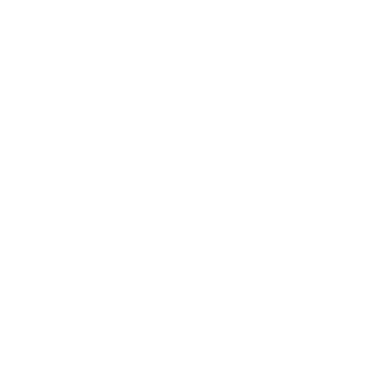

In [11]:
# Create a list of the values: values
values = [ner_categories.get(v) for v in labels]
 
# Create the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
 
# Display the chart
plt.show()

## 0.3.4 Stanford library with NLTK

When using the Stanford library with NLTK, what is needed to get started?

R:/ NLTK, the Stanford Java Libraries and some environment variables to help with integration.

## 0.3.6 Comparing NLTK with spaCy NER

In [12]:
# Instantiate the English model: nlp
nlp = spacy.load('en_core_web_sm')

In [13]:
# Create a new document: doc
doc = nlp(article_m3, disable=['tagger', 'parser', 'matcher'])

In [15]:
# Print all of the found entities and their labels
for ent in doc.ents:
    print(ent.label_, ent.text)

ORG Apple
PERSON Uber
PERSON Travis Kalanick
ORG Uber
PERSON Tim Cook
ORG Apple
CARDINAL Millions
ORG Uber
LOC Silicon Valley’s
NORP democratic
ORG Yahoo
PERSON Marissa Mayer
MONEY 186


In [1]:
print('prueba windows')

prueba windows


In [ ]:
print('ok_')

ok_
